In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score, davies_bouldin_score

import os
import warnings

import scripts_logic


warnings.filterwarnings("ignore")

os.environ["OMP_NUM_THREADS"] = "1"

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [40]:
data = pd.read_csv('../data/cocktail_dataset_reduced.csv')
data.set_index('id', inplace=True)

In [41]:
data.head()

,alcoholic,IBA,category_Cocktail,category_Punch / Party Drink,glass_Brandy snifter,glass_Champagne flute,glass_Cocktail glass,glass_Collins glass,glass_Highball glass,glass_Old-fashioned glass,glass_Pousse cafe glass,glass_Whiskey Glass,glass_Whiskey sour glass,glass_White wine glass,ingredientInName,instructionsLength,tagsCount,ingredientsCount,gin
id,,,,,,,,,,,,,,,,,,,
11000,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0.509804,1.000000,0.75,0
11001,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0.568627,0.444444,0.50,0
11002,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.392157,0.666667,1.00,1
11003,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0.000000,0.222222,0.25,1
11004,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0.294118,0.333333,0.50,0


I will perform Principal Component Analysis (PCA) to reduce the features sequentially to 3 dimensions and then to 2 dimensions.

When I performed PCA after scaling using StandardScaler(), clustering was challenging. Because the data is binary, I used MinMaxScaler() to ensure the data stays within the [0, 1] range. This allowed the variance contribution of the original features to be less dominated by features that previously fell outside of these bounds.

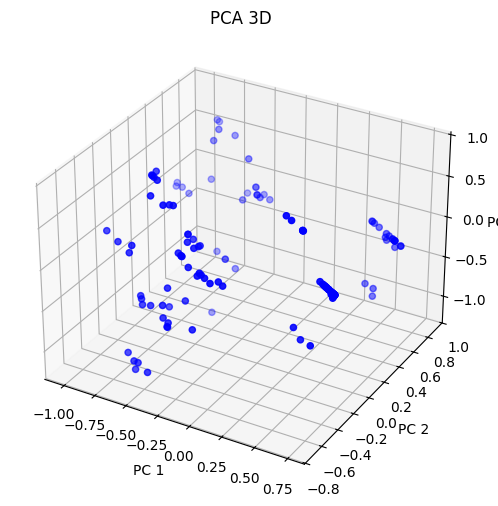

In [42]:
pca = PCA(n_components=3)
data_pca = pca.fit_transform(data)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(data_pca[:, 0], data_pca[:, 1], data_pca[:, 2], c='b', marker='o')

ax.set_title('PCA 3D')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
plt.show()

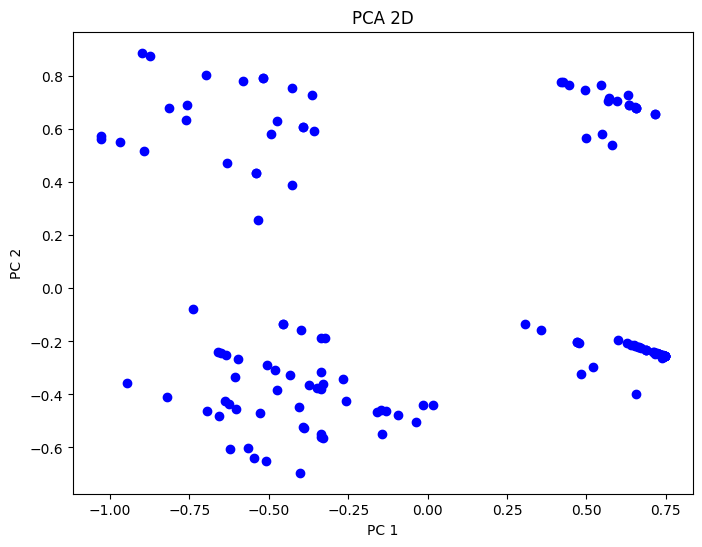

In [43]:
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data)

plt.figure(figsize=(8, 6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c='b', marker='o')
plt.title('PCA 2D')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

In [44]:
pc = pca.components_
explained_variance = pca.explained_variance_ratio_
pca_results = pd.DataFrame(pc, columns=data.columns)

for i in range(len(pc)):
    print(f'PC {i + 1}:')
    
    pc_df = pd.DataFrame({
        'Feature': pca_results.columns,
        'Value': pca_results.iloc[i].values * 100
    })
    
    pc_df = pc_df.sort_values(by='Value', ascending=False)

    for _, row in pc_df.iterrows():
        print(f'{row["Feature"]}: {row["Value"]:.2f}%')
        
    print(f'Explained variance: {explained_variance[i] * 100:.2f}%')
    print()


PC 1:
glass_Cocktail glass: 79.54%
category_Cocktail: 2.50%
glass_Brandy snifter: 0.04%
alcoholic: -0.00%
category_Punch / Party Drink: -0.31%
glass_Pousse cafe glass: -0.96%
glass_White wine glass: -1.01%
glass_Whiskey Glass: -1.02%
glass_Champagne flute: -3.98%
tagsCount: -4.10%
IBA: -6.69%
glass_Collins glass: -7.98%
gin: -9.12%
glass_Whiskey sour glass: -11.62%
instructionsLength: -14.09%
glass_Highball glass: -19.71%
ingredientsCount: -23.16%
glass_Old-fashioned glass: -33.00%
ingredientInName: -33.05%
Explained variance: 24.13%

PC 2:
gin: 93.73%
glass_Highball glass: 17.74%
glass_Cocktail glass: 14.18%
ingredientsCount: 9.62%
ingredientInName: 7.55%
instructionsLength: 5.68%
category_Cocktail: 2.84%
glass_White wine glass: 2.01%
glass_Whiskey sour glass: 1.26%
alcoholic: 0.00%
glass_Whiskey Glass: -0.97%
glass_Brandy snifter: -1.39%
category_Punch / Party Drink: -1.75%
glass_Pousse cafe glass: -2.44%
tagsCount: -3.62%
glass_Collins glass: -6.86%
glass_Champagne flute: -8.39%
gla

Currently, the clusters are visibly distinct, which is relatively a good sign. However, there is a certain relative anomaly: in the first principal component (PCA1), nearly 80% of the variance influence comes from the feature glass_cocktail_glass. This is one of the 11 glass categories that appears in nearly 50% of the analyzed drinks, so its influence may stem from its frequency.

I will visualize its impact in space.

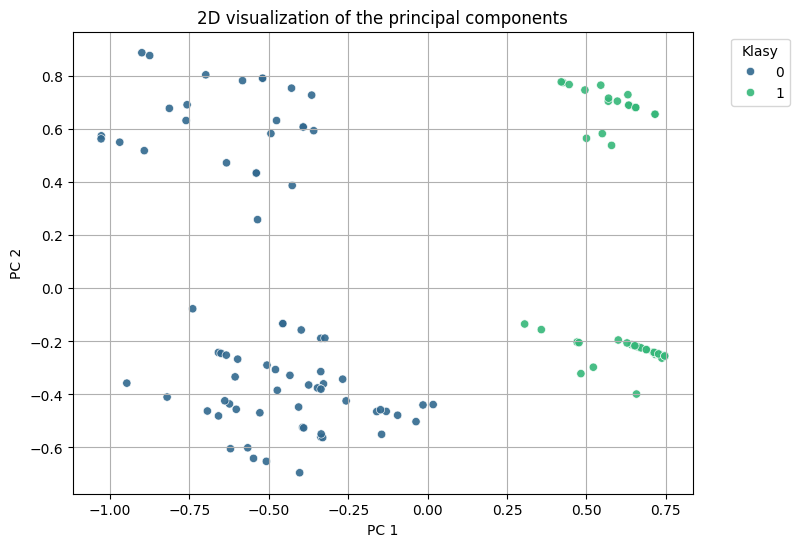

In [45]:
labels = data['glass_Cocktail glass'] 

plt.figure(figsize=(8, 6))
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=labels, palette='viridis', alpha=0.9)
plt.title('2D visualization of the principal components')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(title='Klasy', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

This result shows an overly optimistic outcome of clustering, where the significant contribution of dominant features to the components results in a cluster distribution that resembles a combination of two data features with added noise, which is the variance coming from other features. This needs to be normalized.

Alternatively, one might seek another logic arising from the binary nature of the data, which somewhat explains the dominant nature of individual features.

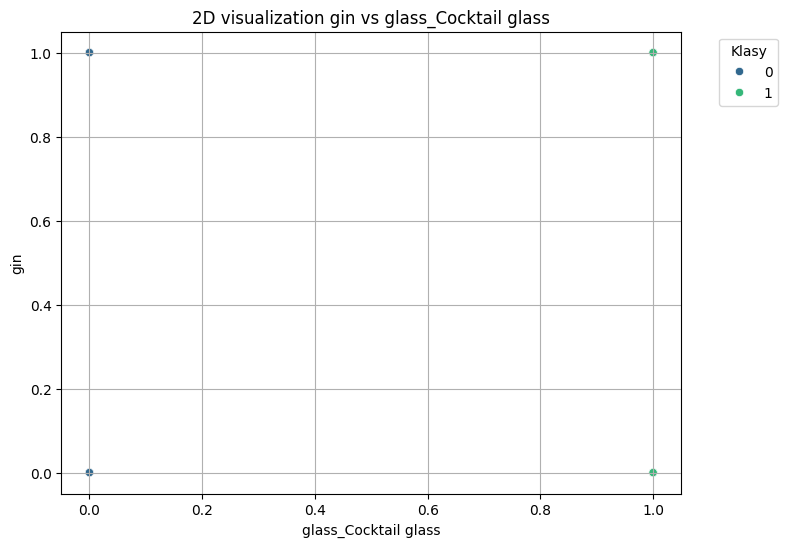

In [46]:
# plot data glass cocktail glass vs gin
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data['glass_Cocktail glass'], y=data['gin'], hue=labels, palette='viridis', alpha=1)
plt.title('2D visualization gin vs glass_Cocktail glass')
plt.xlabel('glass_Cocktail glass')
plt.ylabel('gin')
plt.legend(title='Klasy', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


I will check how many dimensions to reduce the dataset to in order to retain 90% of the variance.

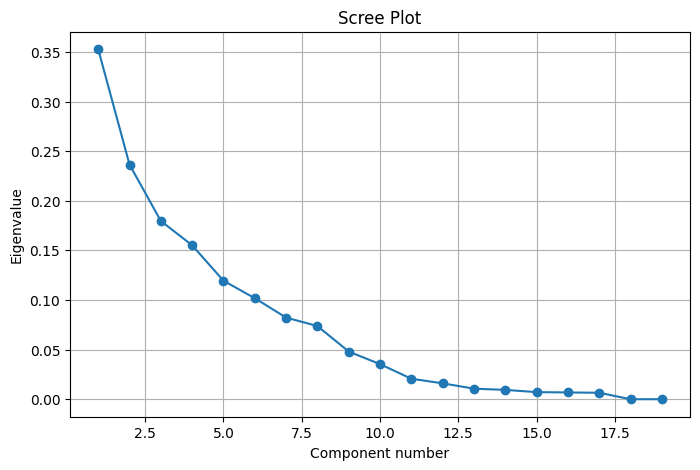

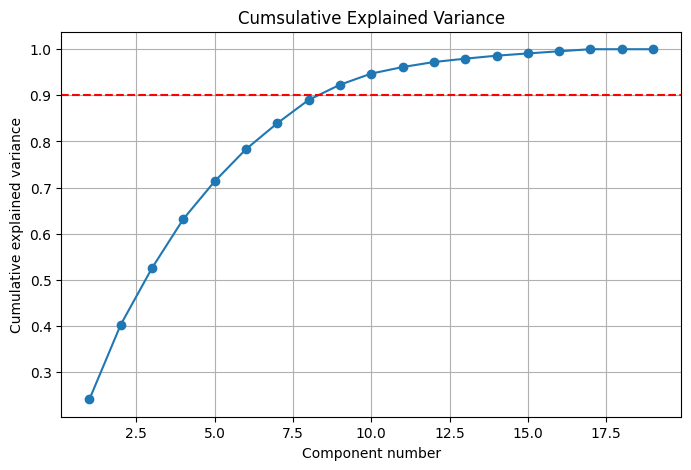

In [47]:
pca = PCA()
pca.fit(data)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_) + 1), pca.explained_variance_, marker='o')
plt.title('Scree Plot')
plt.xlabel('Component number')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.title('Cumsulative Explained Variance')
plt.xlabel('Component number')
plt.ylabel('Cumulative explained variance')
plt.axhline(y=0.90, color='r', linestyle='--')  
plt.grid()
plt.show()

In [48]:
# pca for 6 components
pca = PCA(n_components=6)
data_pca = pca.fit_transform(data)

pc = pca.components_
explained_variance = pca.explained_variance_ratio_
pca_results = pd.DataFrame(pc, columns=data.columns)

for i in range(len(pc)):
    print(f'PC {i + 1}:')
    
    pc_df = pd.DataFrame({
        'Feature': pca_results.columns,
        'Value': pca_results.iloc[i].values * 100
    })
    
    pc_df = pc_df.sort_values(by='Value', ascending=False)

    for _, row in pc_df.iterrows():
        print(f'{row["Feature"]}: {row["Value"]:.2f}%')
        
    print(f'Explained variance: {explained_variance[i] * 100:.2f}%')
    print()

data_pca_df = pd.DataFrame(data_pca, columns=[f'PC{i+1}' for i in range(6)])


PC 1:
glass_Cocktail glass: 79.54%
category_Cocktail: 2.50%
glass_Brandy snifter: 0.04%
alcoholic: -0.00%
category_Punch / Party Drink: -0.31%
glass_Pousse cafe glass: -0.96%
glass_White wine glass: -1.01%
glass_Whiskey Glass: -1.02%
glass_Champagne flute: -3.98%
tagsCount: -4.10%
IBA: -6.69%
glass_Collins glass: -7.98%
gin: -9.12%
glass_Whiskey sour glass: -11.62%
instructionsLength: -14.09%
glass_Highball glass: -19.71%
ingredientsCount: -23.16%
glass_Old-fashioned glass: -33.00%
ingredientInName: -33.05%
Explained variance: 24.13%

PC 2:
gin: 93.73%
glass_Highball glass: 17.74%
glass_Cocktail glass: 14.18%
ingredientsCount: 9.62%
ingredientInName: 7.55%
instructionsLength: 5.68%
category_Cocktail: 2.84%
glass_White wine glass: 2.01%
glass_Whiskey sour glass: 1.26%
alcoholic: 0.00%
glass_Whiskey Glass: -0.97%
glass_Brandy snifter: -1.39%
category_Punch / Party Drink: -1.75%
glass_Pousse cafe glass: -2.44%
tagsCount: -3.62%
glass_Collins glass: -6.86%
glass_Champagne flute: -8.39%
gla

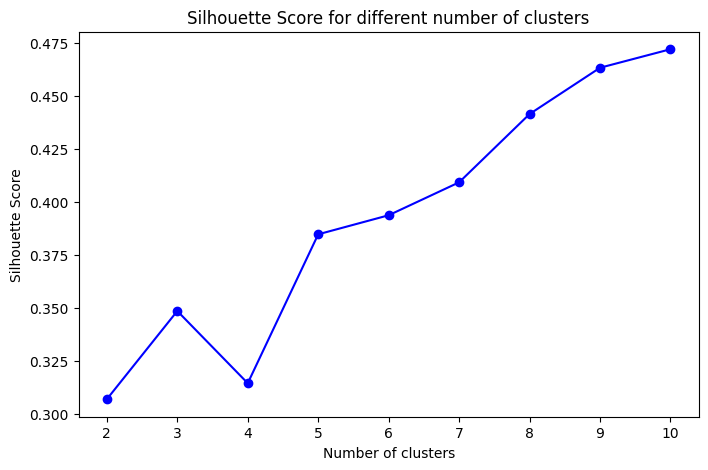

In [49]:
silhouette_scores = []
K = range(2, 11) 
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_pca_df)
    silhouette_scores.append(silhouette_score(data_pca_df, kmeans.labels_))

plt.figure(figsize=(8, 5))
plt.plot(K, silhouette_scores, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for different number of clusters')
plt.show()

In [50]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(data_pca_df)

data_pca_df['Cluster'] = kmeans.labels_

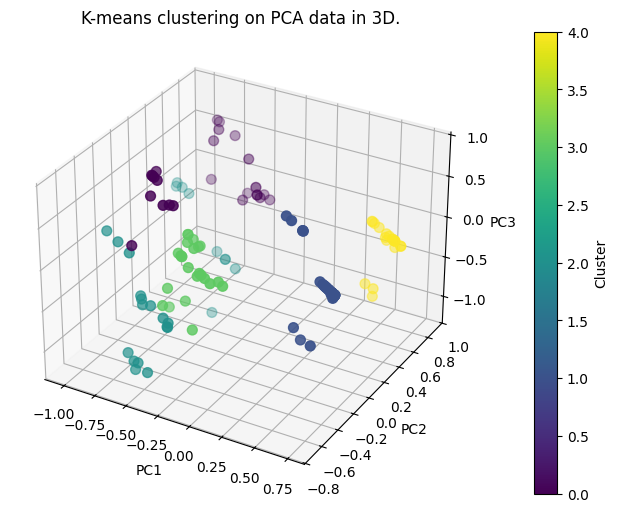

In [51]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(data_pca_df['PC1'], data_pca_df['PC2'], data_pca_df['PC3'], 
                     c=data_pca_df['Cluster'], cmap='viridis', s=50)

ax.set_title('K-means clustering on PCA data in 3D.')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Cluster')
plt.show()

The presented clusters seem to lack significant meaning, as the data in one area is mixed. This is due to the fact that the clusters were created in a **7-dimensional space** and then flattened to **3 dimensions**. In this way, a larger portion of the **variance** has been preserved.

The division into **4 visual clusters** visible in **3D** arises purely from the **binary nature** of the data.

Categorical data—{0, 1} or continuous within the range [0, 1]—when plotted in **3 dimensions**, resemble rather **4 or 8 clusters**. This is because \(2^3 = 8\).

This is confirmed by the **Silhouette score**, which has dips at values that are **powers of 2**: specifically, **2, 4, and 8**.

This explains why the **PCA components** tend to assign certain features **dominant positions**.

Therefore, it would be reasonable to reduce the original data to **3 features**, perform clustering, and visualize it in **3 dimensions** since \(2^3 = 8\).


Variance explained by 3 components: 52.59%


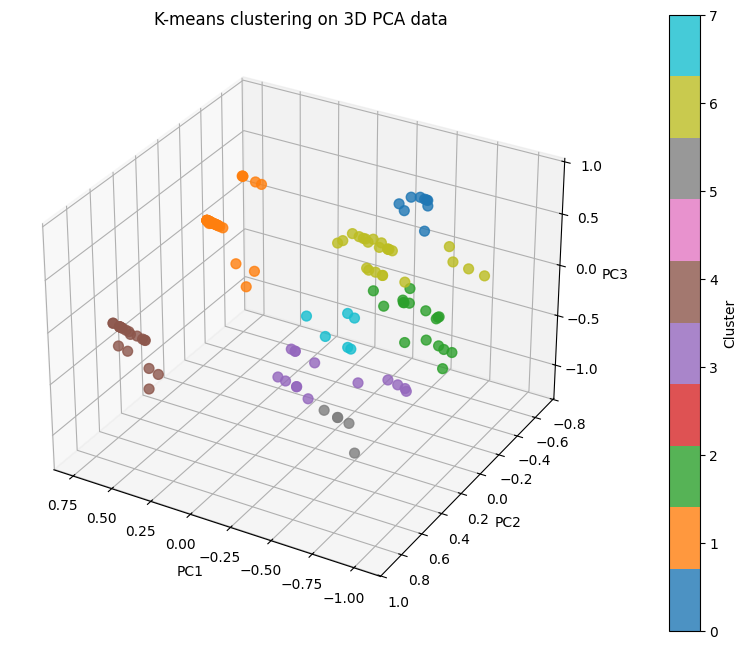

In [52]:
# Reducing the original data to 3 features, performing clustering for 8 clusters, and visualizing in 3 dimensions. Because 2^3=8

pca = PCA(n_components=3)
data_pca = pca.fit_transform(data)

explained_variance = pca.explained_variance_ratio_
explained_variance = np.sum(explained_variance)
print(f'Variance explained by 3 components: {explained_variance * 100:.2f}%')

n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(data_pca)

data_pca_df = pd.DataFrame(data_pca, columns=[f'PC{i+1}' for i in range(3)])
data_pca_df['Cluster'] = kmeans.labels_

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(data_pca_df['PC1'], data_pca_df['PC2'], data_pca_df['PC3'],
                     c=data_pca_df['Cluster'], cmap='tab10', s=50, alpha=0.8)  

ax.set_title('K-means clustering on 3D PCA data')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

ax.view_init(elev=30, azim=120)

cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Cluster')
plt.show()

<img src="../final_clusters.gif" width="1000" />

In [53]:
davies_bouldin_score(data_pca_df, kmeans.labels_)

np.float64(0.2783143360063194)

In [54]:
silhouette_score(data_pca_df, kmeans.labels_)

np.float64(0.8103345945740202)

Good results.

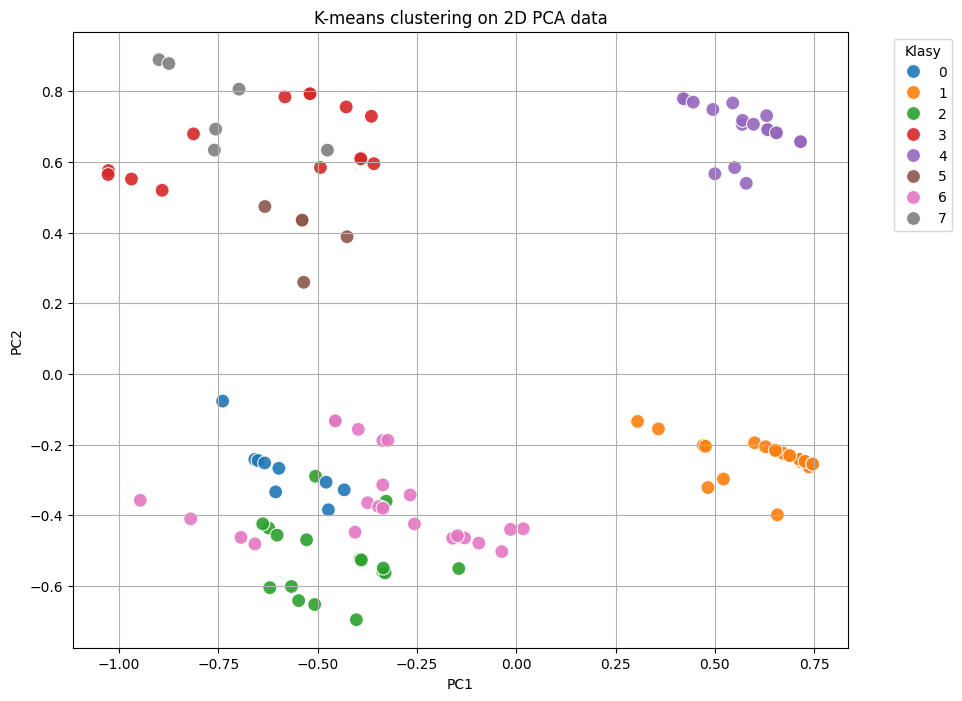

In [55]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x=data_pca_df['PC1'], y=data_pca_df['PC2'], hue=data_pca_df['Cluster'], 
                palette='tab10', alpha=0.9, s=100) 
plt.title('K-means clustering on 2D PCA data')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Klasy', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

I am also checking DBSCAN, instead of GridSearchCV I will use a loop because I had a trouble with error handling for Silhouette score.

In [56]:
X = data_pca_df[['PC1', 'PC2', 'PC3']]

eps_values = np.arange(0.1, 1.1, 0.1) 
min_samples_values = range(2, 11) 

best_silhouette = -1  
best_eps = None
best_min_samples = None

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(X)

        if len(set(dbscan.labels_)) > 1:  
            silhouette_avg = silhouette_score(X, dbscan.labels_)
            
            if silhouette_avg > best_silhouette:
                best_silhouette = silhouette_avg
                best_eps = eps
                best_min_samples = min_samples

print("FOR DBSCAN:")
print(f'Best params - eps: {best_eps}, min_samples: {best_min_samples}, Silhouette Score: {best_silhouette}')

best_dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
best_dbscan.fit(X)

data_pca_df['Cluster'] = best_dbscan.labels_

if len(set(best_dbscan.labels_)) > 1:
    silhouette_avg = silhouette_score(X, best_dbscan.labels_)
    print(f'FInal Silhouette Score: {silhouette_avg}')
else:
    print('Not enougt clusters for silhouette score.')


FOR DBSCAN:
Best params - eps: 0.30000000000000004, min_samples: 2, Silhouette Score: 0.7100368602671456
FInal Silhouette Score: 0.7100368602671456


It follows that the KMEAN algorithm is better for the studied data.

Continuation in notebook: 6_Results_and_evaluation.ipynb